<a href="https://colab.research.google.com/github/Tyred/TimeSeriesClassification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [426]:
!pip install -q -U tensorflow-addons

In [427]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras

from tensorflow.keras.layers import Conv1D, Activation, Dense, Flatten, \
                                    MaxPooling1D, GlobalAveragePooling1D, Dropout
%matplotlib inline

# Reading Dataset from UCR Archive

In [428]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')
tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", 
                        delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", 
                        delimiter="\t",)

train_labels = np.array([int(label) for label in tr_data[: ,0]]) 
test_labels  = np.array([int(label) for label in te_data[:, 0]])
print("Labels:", np.unique(train_labels))

Dataset: HandOutlines
Labels: [0 1]


# Some preprocessing

In [429]:
num_classes = len(np.unique(train_labels))

train_data  = tr_data[:, 1:] 
test_data   = te_data[:, 1:]

train_data = tf.cast(train_data, tf.float32)
test_data  = tf.cast(test_data , tf.float32)

train_data = tf.expand_dims(train_data, axis=-1)
test_data  = tf.expand_dims(test_data , axis=-1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

serie_length = train_data.shape[1]

Train data shape: (1000, 2709, 1)
Test data shape: (370, 2709, 1)


# CNN Model

In [430]:
# Convolutional Autoencoder with MaxPooling:
class CNN(tf.keras.Model):
    def __init__(self, num_classes): #, serie_length):
        super(CNN, self).__init__()
        self.conv_1  = Conv1D(filters=64,
                              kernel_size=3,
                              activation='swish', padding='same',
                              kernel_initializer="he_uniform", 
                              kernel_regularizer=keras.regularizers.l2(1e-4)) 
        self.gn_1    = tfa.layers.GroupNormalization(32)
        self.max_1   = MaxPooling1D(2)
        
        self.conv_2  = Conv1D(filters=128, 
                              kernel_size=3,
                              activation='swish', padding='same',
                              kernel_initializer="he_uniform", 
                              kernel_regularizer=keras.regularizers.l2(1e-4))
        self.gn_2    = tfa.layers.GroupNormalization(32)
        self.max_2   = MaxPooling1D(2)
        
        self.conv_3  = Conv1D(filters=256, 
                              kernel_size=3,
                              activation='swish', padding='same',
                              kernel_initializer="he_uniform", 
                              kernel_regularizer=keras.regularizers.l2(1e-4))
        self.gn_3    = tfa.layers.GroupNormalization(32)
        self.max_3   = MaxPooling1D(2)

        self.conv_4  = Conv1D(filters=512, 
                              kernel_size=3,
                              activation='swish', padding='same',
                              kernel_initializer="he_uniform", 
                              kernel_regularizer=keras.regularizers.l2(1e-4))
        self.gn_4    = tfa.layers.GroupNormalization(32)
        self.max_4   = MaxPooling1D(2)

        self.flatten = Flatten()
        
        #self.avg     = GlobalAveragePooling1D()

        self.dense_1 = Dense(512, activation='swish')
        self.dropout = dropout = Dropout(0.5)
        self.clf     = Dense(num_classes, activation='softmax')
     
    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.gn_1(x)
        x = self.max_1(x)

        x = self.conv_2(x)
        x = self.gn_2(x)
        x = self.max_2(x)

        x = self.conv_3(x)
        x = self.gn_3(x)
        x = self.max_3(x)

        x = self.conv_4(x)
        x = self.gn_4(x)
        x = self.max_4(x)

        x = self.flatten(x)
        #x = self.avg(x)
        x = self.dense_1(x)
        x = self.dropout(x)
        return self.clf(x)

    def model(self):
        x = keras.layers.Input(shape=(serie_length, 1))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [431]:
cnn = CNN(num_classes)

In [432]:
cnn.model().summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 2709, 1)]         0         
_________________________________________________________________
conv1d_240 (Conv1D)          (None, 2709, 64)          256       
_________________________________________________________________
group_normalization_240 (Gro (None, 2709, 64)          128       
_________________________________________________________________
max_pooling1d_240 (MaxPoolin (None, 1354, 64)          0         
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 1354, 128)         24704     
_________________________________________________________________
group_normalization_241 (Gro (None, 1354, 128)         256       
_________________________________________________________________
max_pooling1d_241 (MaxPoolin (None, 677, 128)          0  

# Train

In [433]:
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

batch_size = 32
epochs = 50

history = cnn.fit(train_data, train_labels, 
          epochs=epochs, 
          batch_size=batch_size)

Epoch 1/50
32/32 [==============================] - 3s 59ms/step - loss: 18.4876 - accuracy: 0.7040
Epoch 2/50
32/32 [==============================] - 2s 57ms/step - loss: 1.2336 - accuracy: 0.8080
Epoch 3/50
32/32 [==============================] - 2s 58ms/step - loss: 0.7126 - accuracy: 0.8250
Epoch 4/50
32/32 [==============================] - 2s 58ms/step - loss: 0.7155 - accuracy: 0.8210
Epoch 5/50
32/32 [==============================] - 2s 58ms/step - loss: 0.6310 - accuracy: 0.8230
Epoch 6/50
32/32 [==============================] - 2s 58ms/step - loss: 0.6129 - accuracy: 0.8480
Epoch 7/50
32/32 [==============================] - 2s 58ms/step - loss: 0.6065 - accuracy: 0.8520
Epoch 8/50
32/32 [==============================] - 2s 59ms/step - loss: 0.6532 - accuracy: 0.8490
Epoch 9/50
32/32 [==============================] - 2s 58ms/step - loss: 0.6750 - accuracy: 0.8400
Epoch 10/50
32/32 [==============================] - 2s 58ms/step - loss: 0.6710 - accuracy: 0.8480
Epoch 11

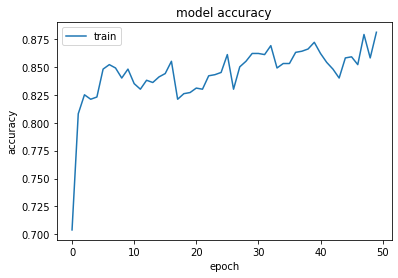

In [434]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

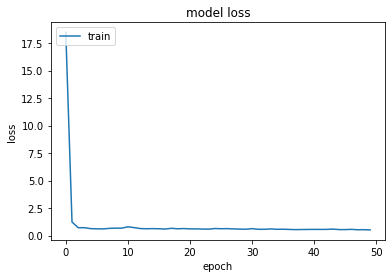

In [435]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Test

In [436]:
_, acc = cnn.evaluate(test_data, test_labels, verbose = False)

print('Accuracy = %.2f' % (acc*100) + '%')

Accuracy = 90.27%
